# Conditional VAE Demo

This notebook contains code for conditional varitational auto-encoder with cyclical kl annealing.

In [ ]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
(images_train, label), _ = mnist.load_data()
label = np.eye(np.unique(label).shape[0])[label]
images_train = 1 - images_train.astype(float)/ 255
images_train = images_train[..., np.newaxis]
print (images_train.shape, label.shape)

(60000, 28, 28, 1) (60000, 10)


In [3]:
def encoder(latent):
    inp = tf.keras.layers.Input([28, 28, 1])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=2,
                               padding='same',activation=tf.nn.leaky_relu)(inp)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2,
                               padding='same',activation=tf.nn.leaky_relu)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2,
                               padding='valid',activation=tf.nn.leaky_relu)(x)
    
    x = tf.reshape(x, (-1, 64))
    x = tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(x)
    
    z_log_sigma_sq = tf.keras.layers.Dense(latent)(x)
    z_mu = tf.keras.layers.Dense(latent)(x)
    
    sample = tf.random.normal(tf.shape(z_log_sigma_sq))
    latent_z = sample * tf.sqrt(tf.exp(z_log_sigma_sq)) + z_mu  
    
    out = tf.stack([latent_z, z_log_sigma_sq, z_mu], -1)
    model = tf.keras.Model(inp, out)
    return model

def decoder(latent):
    
    latent = tf.keras.layers.Input([latent], name='latent')
    cond = tf.keras.layers.Input([10], name='cond')
    
    inp = tf.concat([latent, cond], -1)
    
    x = tf.keras.layers.Dense(units=(32), use_bias=False,activation=tf.nn.leaky_relu)(inp)
    x = tf.reshape(x, (-1, 1, 1, 32))
    x = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=7,strides=1,
                                        padding='valid',use_bias=False,activation=tf.nn.leaky_relu)(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=5,strides=2,
                                        padding='same',use_bias=False,activation=tf.nn.leaky_relu)(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=5,strides=2,
                                        padding='same',use_bias=False, activation='sigmoid')(x)
    
    model = tf.keras.Model([latent, cond], x)
    return model


class CVAE(tf.keras.Model):

    def __init__(self, dec, enc, cyclical_kl=True, coef=2):
        super().__init__()
        self.dec = dec
        self.enc = enc
        self.global_step = tf.Variable(0, dtype=tf.float32, name='step')
        self.cyclical_kl = cyclical_kl
        self.coef = coef
        
    def recons_loss(self, true, pred):
        return tf.reduce_mean(tf.reduce_sum((true - pred)**2, (1,2,3)))
    
    def latent_loss(self, z_log_sigma_sq, z_mu):
        return tf.reduce_mean(-0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mu) - tf.exp(z_log_sigma_sq), axis=-1))
    
    def call(self, inputs):
        out = self.enc(inputs)
        x = self.dec(out[..., 0])
        return x
        
    def train_step(self, inputs):
        inp, cond = inputs
        train_vars = self.trainable_variables
        
        with tf.GradientTape() as tape:

            out = self.enc(inp)
            
            latent_z = out[..., 0]
            z_log_sigma_sq = out[..., 1]
            z_mu = out[..., 2]
            
            x = self.dec([latent_z, cond])
            
            self.global_step.assign_add(tf.constant(1, tf.float32))
            
            if self.cyclical_kl:
                coef = self.coef * tf.math.minimum(tf.math.floormod(self.global_step, 100) / 100, 0.5) * 2
            else:
                coef = self.coef
                
            latent_loss = self.latent_loss(z_log_sigma_sq, z_mu)
            recons_loss = self.recons_loss(inp, x)
            loss = recons_loss + latent_loss * coef  
            
        recons_grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(recons_grads, train_vars))

        return {'recons_loss': recons_loss, 'latent_loss':latent_loss, 'global_step':self.global_step}

In [4]:
latent=2
model = CVAE(decoder(latent=latent), 
            encoder(latent=latent), 
            cyclical_kl=True)
model.compile(optimizer=tf.keras.optimizers.Adam())
model.fit(x=images_train, y=label,  batch_size=256, epochs=20)

Epoch 1/20
235/235 [==============================] - 7s 20ms/step - recons_loss: 56.2724 - latent_loss: 2.2546 - global_step: 118.4707
Epoch 2/20
235/235 [==============================] - 5s 19ms/step - recons_loss: 34.3619 - latent_loss: 2.0445 - global_step: 353.4389
Epoch 3/20
235/235 [==============================] - 5s 19ms/step - recons_loss: 31.4554 - latent_loss: 2.4969 - global_step: 588.3731
Epoch 4/20
235/235 [==============================] - 5s 19ms/step - recons_loss: 30.3313 - latent_loss: 2.7543 - global_step: 823.2859
Epoch 5/20
235/235 [==============================] - 5s 19ms/step - recons_loss: 29.8839 - latent_loss: 2.6836 - global_step: 1058.1815
Epoch 6/20
235/235 [==============================] - 4s 19ms/step - recons_loss: 29.4828 - latent_loss: 2.7658 - global_step: 1293.0685
Epoch 7/20
235/235 [==============================] - 5s 19ms/step - recons_loss: 28.9858 - latent_loss: 2.9338 - global_step: 1527.9411
Epoch 8/20
235/235 [=========================

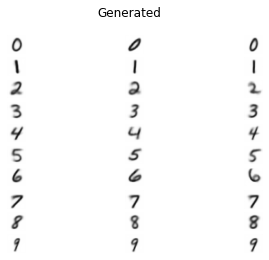

In [11]:
def img_grid(imgs, rows, cols, title):
    fig = plt.figure()
    for i, j in np.ndindex(rows, cols):
        plt.subplot(rows, cols, i*cols+j+1)
        plt.imshow(np.repeat(imgs[i*cols+j], 3, -1))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

cols = 3
rows = 10
r = np.random.normal(0, 1, size=(rows*cols, latent))    
c = np.eye(10)[:, np.newaxis].repeat(cols, 1)
c = c.reshape(-1, 10)

gen = model.dec([r, c]).numpy()    
img_grid(gen, rows, cols, 'Generated')